In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London').text

Get the table

In [3]:
BS = BeautifulSoup(source,'lxml')

Table = BS.find('table',{'class':'wikitable sortable'})

In [4]:
head = Table.find_all('th')
head = [th.text.strip() for th in head]
head = head[:2]
x = head[1].split('\xa0')
x = ' '.join(x)
head.pop()
head.append(x)
head

['Location', 'London borough']

In [5]:
rows = []
for tr in Table.find_all('tr'):
    tds = tr.find_all('td')
    rows.append(tds)
    if not tds:
        continue
del rows[0]

col_0 = []
for i in range(len(rows)):
    col_0.append(rows[i][0])
Locations = []
for location in col_0:
    Locations.append(location.text)
for index, ele in enumerate(Locations):
    if '(' in ele:
        Locations[index] = Locations[index].split('(')[0]
for index, ele in enumerate(Locations):
    if ',' in ele:
        Locations[index] = Locations[index].split(',')[0]        
    
col_1 = []
for i in range(len(rows)):
    col_1.append(rows[i][1])
Boroughs = []
for borough in col_1:
    Boroughs.append(borough.text)
for index, ele in enumerate(Boroughs):
    if '[' in ele:
        Boroughs[index] = Boroughs[index].split('[')[0]
for index, ele in enumerate(Boroughs):
    if ',' in ele:
        Boroughs[index] = Boroughs[index].split(',')[0] 

### Transfor address to latitude and longitude

In [6]:
latitude = []
longitude = []
for i in range(len(Locations)):
    address = str(Locations[i]+', '+ Boroughs[i] + ', England')
    geolocator = Nominatim(user_agent="london_explorer")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    location = geolocator.geocode(address)
    try: 
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        latitude.append("Cant Found")
        longitude.append("Cant Found")   

In [7]:
head.append('Latitude')
head.append('Longitude')

In [8]:
df = pd.DataFrame(list(zip(Locations, Boroughs, latitude, longitude)), 
               columns = head) 
df.head()

Location London borough Latitude  Longitude
0   Abbey Wood         Bexley    51.49   0.132891
1        Acton         Ealing  51.5081  -0.273261
2    Addington        Croydon  51.3573 -0.0408444
3   Addiscombe        Croydon  51.3797 -0.0742821
4  Albany Park         Bexley  51.4354   0.125965

In [9]:
#可以刪掉
df.to_pickle('Location_London_pickle.csv')
df.to_csv('Location_London.csv')

In [10]:
df=df[df.Latitude != "Cant Found"]

In [11]:
print('{} boroughs\
      {} neighborhoods.'.format(len(df['London borough'].unique()),
        df.shape[0]))

33 boroughs      527 neighborhoods.


In [15]:
address = 'London'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
lat_e = location.latitude
long_e = location.longitude
print('London Latitude: {}, Longitude: {}.'.format(lat_e, long_e))

London Latitude: 51.5073219, Longitude: -0.1276474.


In [16]:
map_london = folium.Map(location=[lat_e, long_e], zoom_start=10)
for lat, lng, borough, location in zip(df['Latitude'], df['Longitude'], df['London borough'], df['Location']):
    label = '{}, {}'.format(location, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_opacity=0.2,
        parse_html=False).add_to(map_london)  
    
map_london

In [17]:
"""這個可以刪掉"""
limit = 200
client_id = 'BXW3JJWNGTFKZAXXSRDC0AEA0NZDT4OLDKF4LYI55FM53ENH'
clined_secret = 'CAAFQOXEHJKD0R0RDKJ1CFNUOI4UKU4AJSMCFKRQGFG3VVCP'
verson = '20210104'

print('Your credentails:')
print('client_id: ' + client_id)
print('clined_secret:' + clined_secret)

Your credentails:
client_id: BXW3JJWNGTFKZAXXSRDC0AEA0NZDT4OLDKF4LYI55FM53ENH
clined_secret:CAAFQOXEHJKD0R0RDKJ1CFNUOI4UKU4AJSMCFKRQGFG3VVCP


In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            clined_secret, 
            verson, 
            lat, 
            lng, 
            radius, 
            limit)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
London_venues = getNearbyVenues(names=df['Location'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Abbey Wood
Acton
Addington
Addiscombe
Albany Park
Aldgate
Aldwych
Alperton
Anerley
Angel
Aperfield
Archway
Ardleigh Green
Arkley
Arnos Grove
Balham
Bankside
Barbican
Barking
Barkingside
Barnehurst
Barnes
Barnes Cray
Barnet Gate
Barnet 
Barnsbury
Battersea
Bayswater
Beckenham
Beckton
Becontree
Becontree Heath
Beddington
Bedford Park
Belgravia
Bellingham
Belmont
Belmont
Belsize Park
Belvedere
Bermondsey
Berrylands
Bethnal Green
Bexley 
Bexleyheath 
Bickley
Biggin Hill
Blackfen
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Blendon
Bloomsbury
Botany Bay
Bounds Green
Bow
Bowes Park
Brentford
Brent Cross
Brent Park
Brimsdown
Brixton
Brockley
Bromley
Bromley 
Bromley Common
Brompton
Brondesbury
Brunswick Park
Bulls Cross
Burnt Oak
Burroughs
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Canning Town
Canonbury
Carshalton
Castelnau
Castle Green
Catford
Chadwell Heath
Chalk Farm
Charing Cross
Charlton
Chase Cross
Cheam
Chelsea
Chelsfield
Chessington
Childs Hill
Chinatown
Chinbr

In [20]:
print(London_venues.shape)
London_venues.head()
London_venues[London_venues['Venue'].str.contains('Walthamstow')]

(12090, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
6426    Lea Bridge              51.562144               -0.045827   
11067  Walthamstow              51.581524               -0.023759   
11074  Walthamstow              51.581524               -0.023759   
11085  Walthamstow              51.581524               -0.023759   
11096  Walthamstow              51.581524               -0.023759   

                                                   Venue  Venue Latitude  \
6426                                 Walthamstow Marshes       51.566400   
11067                         The Gym London Walthamstow       51.584026   
11074                        Walthamstow Farmers' Market       51.584394   
11085                                 Walthamstow Market       51.583932   
11096  Walthamstow Queen's Road London Overground Sta...       51.581587   

       Venue Longitude        Venue Category  
6426         -0.047035       Nature Preserve  
11067        -0.022037  Gym / Fitness Center  
11074        -0.021783        Farmers Market  
11085        -0.023171                Market  
11096        -0.023874         Train Station

Groupby 'Neighborhood'

In [21]:
London_venues.groupby('Neighborhood')
print('There are {} uniques categories.'.format(len(London_venues['Venue Category'].unique())))

There are 416 uniques categories.


### Extracting data of restaurant

In [22]:
London_restaurants = London_venues[London_venues['Venue Category'].str.contains("Restaurant")]

In [23]:
London_restaurants

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
8               Acton              51.508140               -0.273261   
15              Acton              51.508140               -0.273261   
24              Acton              51.508140               -0.273261   
28          Addington              51.357319               -0.040844   
33         Addiscombe              51.379692               -0.074282   
...               ...                    ...                     ...   
12061  Worcester Park              51.378400               -0.241602   
12067  Worcester Park              51.378400               -0.241602   
12075         Yeading              51.527239               -0.399270   
12078        Yiewsley              51.512866               -0.474152   
12082        Yiewsley              51.512866               -0.474152   

                            Venue  Venue Latitude  Venue Longitude  \
8               Amigo's Peri Peri       51.508396        -0.274561   
15         North China Restaurant       51.508251        -0.277435   
24                  Sam's Chicken       51.507193        -0.270431   
28     Number One Chinese Cuisine       51.354569        -0.042584   
33                            KFC       51.380105        -0.073570   
...                           ...             ...              ...   
12061                         KFC       51.378871        -0.241862   
12067       Surrey Nefis Lebanese       51.379849        -0.243652   
12075              Pang's Cottage       51.528545        -0.398557   
12078                     Go Sing       51.508947        -0.473809   
12082                         KFC       51.512564        -0.472315   

             Venue Category  
8      Fast Food Restaurant  
15       Chinese Restaurant  
24     Fast Food Restaurant  
28       Chinese Restaurant  
33     Fast Food Restaurant  
...                     ...  
12061  Fast Food Restaurant  
12067   Lebanese Restaurant  
12075    Chinese Restaurant  
12078    Chinese Restaurant  
12082  Fast Food Restaurant  

[2514 rows x 7 columns]

In [24]:
print('{} cusines(categories) in London.'.format(len(London_restaurants['Venue Category'].unique())))

80 cusines(categories) in London.


### Preprocessing

In [25]:
London_onehot = pd.get_dummies(London_restaurants[['Venue Category']], prefix="", prefix_sep="")

London_onehot['Neighborhood'] = London_restaurants['Neighborhood'] 

fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
8         Acton                  0                   0                    0   
15        Acton                  0                   0                    0   
24        Acton                  0                   0                    0   
28    Addington                  0                   0                    0   
33   Addiscombe                  0                   0                    0   

    Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
8                  0                       0                 0   
15                 0                       0                 0   
24                 0                       0                 0   
28                 0                       0                 0   
33                 0                       0                 0   

    Australian Restaurant  Austrian Restaurant  Brazilian Restaurant  ...  \
8                       0                    0                     0  ...   
15                      0                    0                     0  ...   
24                      0                    0                     0  ...   
28                      0                    0                     0  ...   
33                      0                    0                     0  ...   

    Szechuan Restaurant  Tapas Restaurant  Thai Restaurant  \
8                     0                 0                0   
15                    0                 0                0   
24                    0                 0                0   
28                    0                 0                0   
33                    0                 0                0   

    Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
8                    0                0                              0   
15                   0                0                              0   
24                   0                0                              0   
28                   0                0                              0   
33                   0                0                              0   

    Veneto Restaurant  Vietnamese Restaurant  Xinjiang Restaurant  \
8                   0                      0                    0   
15                  0                      0                    0   
24                  0                      0                    0   
28                  0                      0                    0   
33                  0                      0                    0   

    Yoshoku Restaurant  
8                    0  
15                   0  
24                   0  
28                   0  
33                   0  

[5 rows x 81 columns]

In [26]:
print('Restaurants: {}  Cuisines: {}.'.format(London_onehot.shape[0],(London_onehot.shape[1]-1)))

Restaurants: 2514  Cuisines: 80.


### Groupby Neighborhood to see the proportion of each type of restaurant

In [27]:
London_grouped = London_onehot.groupby('Neighborhood').mean().reset_index()
London_grouped

Neighborhood  Afghan Restaurant  African Restaurant  \
0             Acton                0.0                 0.0   
1         Addington                0.0                 0.0   
2        Addiscombe                0.0                 0.0   
3       Albany Park                0.0                 0.0   
4           Aldgate                0.0                 0.0   
..              ...                ...                 ...   
400        Woodside                0.0                 0.0   
401        Woolwich                0.0                 0.1   
402  Worcester Park                0.0                 0.0   
403         Yeading                0.0                 0.0   
404        Yiewsley                0.0                 0.0   

     American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0                    0.0               0.0                     0.0   
1                    0.0               0.0                     0.0   
2                    0.0               0.0                     0.0   
3                    0.0               0.0                     0.0   
4                    0.0               0.0                     0.0   
..                   ...               ...                     ...   
400                  0.0               0.0                     0.0   
401                  0.0               0.0                     0.0   
402                  0.0               0.0                     0.0   
403                  0.0               0.0                     0.0   
404                  0.0               0.0                     0.0   

     Asian Restaurant  Australian Restaurant  Austrian Restaurant  \
0              0.0000                    0.0                  0.0   
1              0.0000                    0.0                  0.0   
2              0.0000                    0.0                  0.0   
3              0.0000                    0.0                  0.0   
4              0.0625                    0.0                  0.0   
..                ...                    ...                  ...   
400            0.0000                    0.0                  0.0   
401            0.2000                    0.0                  0.0   
402            0.0000                    0.0                  0.0   
403            0.0000                    0.0                  0.0   
404            0.0000                    0.0                  0.0   

     Brazilian Restaurant  ...  Szechuan Restaurant  Tapas Restaurant  \
0                     0.0  ...              0.00000               0.0   
1                     0.0  ...              0.00000               0.0   
2                     0.0  ...              0.00000               0.0   
3                     0.0  ...              0.00000               0.0   
4                     0.0  ...              0.03125               0.0   
..                    ...  ...                  ...               ...   
400                   0.0  ...              0.00000               0.0   
401                   0.0  ...              0.00000               0.0   
402                   0.0  ...              0.00000               0.0   
403                   0.0  ...              0.00000               0.0   
404                   0.0  ...              0.00000               0.0   

     Thai Restaurant  Turkish Restaurant  Udon Restaurant  \
0            0.00000                 0.0              0.0   
1            0.00000                 0.0              0.0   
2            0.00000                 0.0              0.0   
3            0.00000                 0.0              0.0   
4            0.09375                 0.0              0.0   
..               ...                 ...              ...   
400          0.00000                 0.0              0.0   
401          0.10000                 0.0              0.0   
402          0.00000                 0.0              0.0   
403          0.00000                 0.0              0.0   
404          0.00000                 0.0    

### Top 5 types of restaurant for each Neighborhood

In [28]:
num_top_rest = 5

for hood in London_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = London_grouped[London_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_rest))
    print('\n')

----Acton----
                    venue  freq
0    Fast Food Restaurant  0.67
1      Chinese Restaurant  0.33
2       Afghan Restaurant  0.00
3  Okonomiyaki Restaurant  0.00
4        Ramen Restaurant  0.00


----Addington----
                   venue  freq
0     Chinese Restaurant   1.0
1      Afghan Restaurant   0.0
2     Russian Restaurant   0.0
3       Ramen Restaurant   0.0
4  Portuguese Restaurant   0.0


----Addiscombe----
                    venue  freq
0    Fast Food Restaurant   0.5
1      Chinese Restaurant   0.5
2       Afghan Restaurant   0.0
3  Okonomiyaki Restaurant   0.0
4        Ramen Restaurant   0.0


----Albany Park----
                     venue  freq
0        Indian Restaurant   1.0
1        Afghan Restaurant   0.0
2  North Indian Restaurant   0.0
3         Ramen Restaurant   0.0
4    Portuguese Restaurant   0.0


----Aldgate----
                       venue  freq
0          Indian Restaurant  0.09
1  Middle Eastern Restaurant  0.09
2            Thai Restaurant  0.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Top 10 most common venue

In [30]:


#Creating a new dataframe and displaying the top 10 restaurants based on occurance and cuisine for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = London_grouped['Neighborhood']


for ind in np.arange(London_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0        Acton  Fast Food Restaurant    Chinese Restaurant   
1    Addington    Chinese Restaurant    Yoshoku Restaurant   
2   Addiscombe  Fast Food Restaurant    Chinese Restaurant   
3  Albany Park     Indian Restaurant    Yoshoku Restaurant   
4      Aldgate     Indian Restaurant       Thai Restaurant   

  3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
0    Yoshoku Restaurant         English Restaurant    Falafel Restaurant   
1    English Restaurant         Falafel Restaurant  Fast Food Restaurant   
2    Yoshoku Restaurant         English Restaurant    Falafel Restaurant   
3      Greek Restaurant       Ethiopian Restaurant    Falafel Restaurant   
4            Restaurant  Middle Eastern Restaurant    English Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0    Filipino Restaurant     French Restaurant     German Restaurant   
1    Filipino Restaurant     French Restaurant     German Restaurant   
2    Filipino Restaurant     French Restaurant     German Restaurant   
3   Fast Food Restaurant   Filipino Restaurant     French Restaurant   
4  Vietnamese Restaurant   Japanese Restaurant      Asian Restaurant   

    9th Most Common Venue  10th Most Common Venue  
0  Gluten-free Restaurant        Greek Restaurant  
1  Gluten-free Restaurant        Greek Restaurant  
2  Gluten-free Restaurant        Greek Restaurant  
3       German Restaurant  Gluten-free Restaurant  
4      Italian Restaurant        Sushi Restaurant

### Analysis

In [31]:
# Creating new dataframe to determine best k value by dropping first column
London_clustering_testing = London_grouped.drop('Neighborhood', 1)

In [32]:
London_clustering_testing

Afghan Restaurant  African Restaurant  American Restaurant  \
0                  0.0                 0.0                  0.0   
1                  0.0                 0.0                  0.0   
2                  0.0                 0.0                  0.0   
3                  0.0                 0.0                  0.0   
4                  0.0                 0.0                  0.0   
..                 ...                 ...                  ...   
400                0.0                 0.0                  0.0   
401                0.0                 0.1                  0.0   
402                0.0                 0.0                  0.0   
403                0.0                 0.0                  0.0   
404                0.0                 0.0                  0.0   

     Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                 0.0                     0.0            0.0000   
1                 0.0                     0.0            0.0000   
2                 0.0                     0.0            0.0000   
3                 0.0                     0.0            0.0000   
4                 0.0                     0.0            0.0625   
..                ...                     ...               ...   
400               0.0                     0.0            0.0000   
401               0.0                     0.0            0.2000   
402               0.0                     0.0            0.0000   
403               0.0                     0.0            0.0000   
404               0.0                     0.0            0.0000   

     Australian Restaurant  Austrian Restaurant  Brazilian Restaurant  \
0                      0.0                  0.0                   0.0   
1                      0.0                  0.0                   0.0   
2                      0.0                  0.0                   0.0   
3                      0.0                  0.0                   0.0   
4                      0.0                  0.0                   0.0   
..                     ...                  ...                   ...   
400                    0.0                  0.0                   0.0   
401                    0.0                  0.0                   0.0   
402                    0.0                  0.0                   0.0   
403                    0.0                  0.0                   0.0   
404                    0.0                  0.0                   0.0   

     Cajun / Creole Restaurant  ...  Szechuan Restaurant  Tapas Restaurant  \
0                          0.0  ...              0.00000               0.0   
1                          0.0  ...              0.00000               0.0   
2                          0.0  ...              0.00000               0.0   
3                          0.0  ...              0.00000               0.0   
4                          0.0  ...              0.03125               0.0   
..                         ...  ...                  ...               ...   
400                        0.0  ...              0.00000               0.0   
401                        0.0  ...              0.00000               0.0   
402                        0.0  ...              0.00000               0.0   
403                        0.0  ...              0.00000               0.0   
404                        0.0  ...              0.00000               0.0   

     Thai Restaurant  Turkish Restaurant  Udon Restaurant  \
0            0.00000                 0.0              0.0   
1            0.00000                 0.0              0.0   
2            0.00000                 0.0              0.0   
3            0.00000                 0.0              0.0   
4            0.09375                 0.0              0.0   
..               ...                 ...              ...   
400          0.00000                 0.0              0.0   
401          0.10000                 0.0              0.0   
402          0.00000            

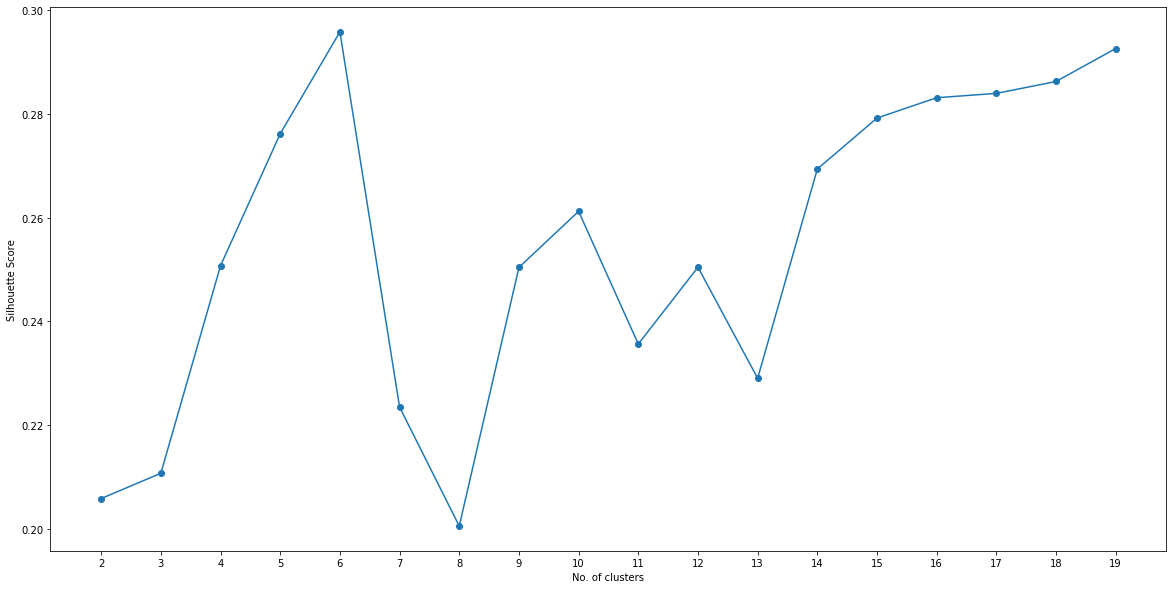

In [33]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
indices = []
scores = []
max_range = 20

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    lct = London_clustering_testing
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(lct)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(lct, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
    

plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [34]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

6

In [35]:
kclusters = opt

London_grouped_clustering = London_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

kmeans.labels_[0:10] 



array([4, 5, 4, 3, 2, 2, 3, 4, 2, 5])

Setting the dataframe with cluster and top 10 venues

In [36]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

London_merged = London_restaurants

London_merged = London_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
London_merged.fillna(0)
London_merged.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
8         Acton              51.508140               -0.273261   
15        Acton              51.508140               -0.273261   
24        Acton              51.508140               -0.273261   
28    Addington              51.357319               -0.040844   
33   Addiscombe              51.379692               -0.074282   

                         Venue  Venue Latitude  Venue Longitude  \
8            Amigo's Peri Peri       51.508396        -0.274561   
15      North China Restaurant       51.508251        -0.277435   
24               Sam's Chicken       51.507193        -0.270431   
28  Number One Chinese Cuisine       51.354569        -0.042584   
33                         KFC       51.380105        -0.073570   

          Venue Category  Cluster Labels 1st Most Common Venue  \
8   Fast Food Restaurant               4  Fast Food Restaurant   
15    Chinese Restaurant               4  Fast Food Restaurant   
24  Fast Food Restaurant               4  Fast Food Restaurant   
28    Chinese Restaurant               5    Chinese Restaurant   
33  Fast Food Restaurant               4  Fast Food Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
8     Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
15    Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
24    Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
28    Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
33    Chinese Restaurant    Yoshoku Restaurant    English Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
8     Falafel Restaurant   Filipino Restaurant     French Restaurant   
15    Falafel Restaurant   Filipino Restaurant     French Restaurant   
24    Falafel Restaurant   Filipino Restaurant     French Restaurant   
28  Fast Food Restaurant   Filipino Restaurant     French Restaurant   
33    Falafel Restaurant   Filipino Restaurant     French Restaurant   

   8th Most Common Venue   9th Most Common Venue 10th Most Common Venue  
8      German Restaurant  Gluten-free Restaurant       Greek Restaurant  
15     German Restaurant  Gluten-free Restaurant       Greek Restaurant  
24     German Restaurant  Gluten-free Restaurant       Greek Restaurant  
28     German Restaurant  Gluten-free Restaurant       Greek Restaurant  
33     German Restaurant  Gluten-free Restaurant       Greek Restaurant

In [37]:
London_merged

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
8               Acton              51.508140               -0.273261   
15              Acton              51.508140               -0.273261   
24              Acton              51.508140               -0.273261   
28          Addington              51.357319               -0.040844   
33         Addiscombe              51.379692               -0.074282   
...               ...                    ...                     ...   
12061  Worcester Park              51.378400               -0.241602   
12067  Worcester Park              51.378400               -0.241602   
12075         Yeading              51.527239               -0.399270   
12078        Yiewsley              51.512866               -0.474152   
12082        Yiewsley              51.512866               -0.474152   

                            Venue  Venue Latitude  Venue Longitude  \
8               Amigo's Peri Peri       51.508396        -0.274561   
15         North China Restaurant       51.508251        -0.277435   
24                  Sam's Chicken       51.507193        -0.270431   
28     Number One Chinese Cuisine       51.354569        -0.042584   
33                            KFC       51.380105        -0.073570   
...                           ...             ...              ...   
12061                         KFC       51.378871        -0.241862   
12067       Surrey Nefis Lebanese       51.379849        -0.243652   
12075              Pang's Cottage       51.528545        -0.398557   
12078                     Go Sing       51.508947        -0.473809   
12082                         KFC       51.512564        -0.472315   

             Venue Category  Cluster Labels 1st Most Common Venue  \
8      Fast Food Restaurant               4  Fast Food Restaurant   
15       Chinese Restaurant               4  Fast Food Restaurant   
24     Fast Food Restaurant               4  Fast Food Restaurant   
28       Chinese Restaurant               5    Chinese Restaurant   
33     Fast Food Restaurant               4  Fast Food Restaurant   
...                     ...             ...                   ...   
12061  Fast Food Restaurant               4   Lebanese Restaurant   
12067   Lebanese Restaurant               4   Lebanese Restaurant   
12075    Chinese Restaurant               5    Chinese Restaurant   
12078    Chinese Restaurant               4  Fast Food Restaurant   
12082  Fast Food Restaurant               4  Fast Food Restaurant   

      2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
8        Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
15       Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
24       Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
28       Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
33       Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
...                     ...                   ...                   ...   
12061  Fast Food Restaurant    Yoshoku Restaurant      Greek Restaurant   
12067  Fast Food Restaurant    Yoshoku Restaurant      Greek Restaurant   
12075    Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
12078    Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
12082    Chinese Restaurant    Yoshoku Restaurant    English Restaurant   

      5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
8        Falafel Restaurant   Filipino Restaurant     French Restaurant   
15       Falafel Restaurant   Filipino Restaurant     French Restaurant   
24       Falafel Restaurant   Filipino Restaurant     French Restaurant   
28     Fast Food Restaurant   Filipino Restaurant     French Restaurant   
33       Falafel Restaurant   Filipino Restaurant     French Restaurant   
...                     ...                   ...                   ...   
12061  Ethiopian Restaurant    Falafel Restauran

In [38]:
London_merged['Cluster Labels'].value_counts()

2    2222
4      97
3      77
1      50
5      41
0      27
Name: Cluster Labels, dtype: int64

### Map

In [39]:

# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, vc in zip(London_merged['Venue Latitude'], London_merged['Venue Longitude'], London_merged['Venue'], London_merged['Cluster Labels'], London_merged['Venue Category']):
    label = folium.Popup(str(poi) +' (' +str(vc) + ') ['+ str(cluster)+']', parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

### Analyzing for each cluster

#### cluster 1

In [40]:
c1 = London_merged.loc[London_merged['Cluster Labels'] == 0, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c1.drop_duplicates()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
597            Barnes            Restaurant       Thai Restaurant   
2486         Chiswick            Restaurant      Kebab Restaurant   
2788       Coney Hall            Restaurant      Kebab Restaurant   
3023           Cowley            Restaurant      Kebab Restaurant   
3483      Dollis Hill            Restaurant      Kebab Restaurant   
3504          Dulwich            Restaurant      Kebab Restaurant   
3668     East Bedfont            Restaurant      Kebab Restaurant   
5127         Hanworth            Restaurant    Chinese Restaurant   
5299        Hazelwood            Restaurant      Kebab Restaurant   
5557     Holland Park            Restaurant   Japanese Restaurant   
6040              Kew            Restaurant      Kebab Restaurant   
6416         Lamorbey            Restaurant    Italian Restaurant   
6501           Leyton            Restaurant      Kebab Restaurant   
6687   Malden Rushett            Restaurant      Kebab Restaurant   
6950      Merton Park            Restaurant      Kebab Restaurant   
7286        Nine Elms            Restaurant     Indian Restaurant   
10502        Tolworth            Restaurant     Indian Restaurant   
10921           Upton            Restaurant      Kebab Restaurant   
11234       Well Hall            Restaurant    Chinese Restaurant   

             3rd Most Common Venue 4th Most Common Venue  \
597               Greek Restaurant    English Restaurant   
2486            English Restaurant  Ethiopian Restaurant   
2788            English Restaurant  Ethiopian Restaurant   
3023            English Restaurant  Ethiopian Restaurant   
3483            English Restaurant  Ethiopian Restaurant   
3504            English Restaurant  Ethiopian Restaurant   
3668            English Restaurant  Ethiopian Restaurant   
5127   Eastern European Restaurant  Ethiopian Restaurant   
5299            English Restaurant  Ethiopian Restaurant   
5557            African Restaurant      Greek Restaurant   
6040            English Restaurant  Ethiopian Restaurant   
6416        Gluten-free Restaurant    English Restaurant   
6501            English Restaurant  Ethiopian Restaurant   
6687            English Restaurant  Ethiopian Restaurant   
6950            English Restaurant  Ethiopian Restaurant   
7286        Gluten-free Restaurant    English Restaurant   
10502       Gluten-free Restaurant    English Restaurant   
10921           English Restaurant  Ethiopian Restaurant   
11234  Eastern European Restaurant  Ethiopian Restaurant   

      5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
597    Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
2486     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
2788     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
3023     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
3483     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
3504     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
3668     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
5127     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
5299     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
5557   Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
6040     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
6416   Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
6501     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
6687     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
6950     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
7286   Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
10502  Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
10921    Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
11

In [41]:
c1_table = London_merged.loc[London_merged['Cluster Labels'] == 0, London_merged.columns[[0]+[3]+[4]+[5]+list(range(8, London_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c1_table['Venue Latitude'], c1_table['Venue Longitude'], c1_table['Venue'], c1_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### cluster 2

In [42]:
c2 = London_merged.loc[London_merged['Cluster Labels'] == 1, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c2.drop_duplicates()

Neighborhood  1st Most Common Venue       2nd Most Common Venue  \
839      Becontree Heath     Turkish Restaurant          Yoshoku Restaurant   
1308                 Bow     Turkish Restaurant          Yoshoku Restaurant   
2718         Cockfosters       Greek Restaurant          Turkish Restaurant   
3950        Emerson Park     Turkish Restaurant          Yoshoku Restaurant   
3959     Enfield Highway     Turkish Restaurant          Yoshoku Restaurant   
4025        Enfield Wash     Turkish Restaurant          Yoshoku Restaurant   
4485          Gidea Park     Turkish Restaurant          Yoshoku Restaurant   
5174           Harringay     Turkish Restaurant          Italian Restaurant   
7515            Old Ford     Turkish Restaurant          Yoshoku Restaurant   
7553              Osidge     Italian Restaurant          Turkish Restaurant   
8604         Shacklewell     Turkish Restaurant  Modern European Restaurant   
9147    South Hornchurch     Turkish Restaurant          Yoshoku Restaurant   
9664            St Johns  Sri Lankan Restaurant          Turkish Restaurant   
10468     Temple Fortune     Italian Restaurant          Turkish Restaurant   
10907  Upper Walthamstow     Turkish Restaurant        Fast Food Restaurant   
11409         West Green     Turkish Restaurant          Yoshoku Restaurant   
11968     Woodford Green     Italian Restaurant          Turkish Restaurant   

      3rd Most Common Venue      4th Most Common Venue  \
839        Greek Restaurant       Ethiopian Restaurant   
1308       Greek Restaurant       Ethiopian Restaurant   
2718     Italian Restaurant         Yoshoku Restaurant   
3950       Greek Restaurant       Ethiopian Restaurant   
3959       Greek Restaurant       Ethiopian Restaurant   
4025       Greek Restaurant       Ethiopian Restaurant   
4485       Greek Restaurant       Ethiopian Restaurant   
5174     Chinese Restaurant  Middle Eastern Restaurant   
7515       Greek Restaurant       Ethiopian Restaurant   
7553     Yoshoku Restaurant           Greek Restaurant   
8604             Restaurant           Cuban Restaurant   
9147       Greek Restaurant       Ethiopian Restaurant   
9664     Yoshoku Restaurant       Ethiopian Restaurant   
10468    Yoshoku Restaurant           Greek Restaurant   
10907    Yoshoku Restaurant           Greek Restaurant   
11409      Greek Restaurant       Ethiopian Restaurant   
11968    Yoshoku Restaurant           Greek Restaurant   

          5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
839          Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
1308         Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
2718       Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
3950         Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
3959         Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
4025         Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
4485         Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
5174         Yoshoku Restaurant      Greek Restaurant    Falafel Restaurant   
7515         Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
7553       Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
8604   Mediterranean Restaurant      Greek Restaurant    Falafel Restaurant   
9147         Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
9664         Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
10468      Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
10907      Ethiopian Restaurant    Falafel Restaurant   Filipino Restaurant   
11409        Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
11968      Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   

      8th Most Common Venue 9th Most Common Venue  10th Most Common Venue  
839       French Restaurant     German Restau

In [43]:
c2_table = London_merged.loc[London_merged['Cluster Labels'] == 1, London_merged.columns[[0]+[3]+[4]+[5]+list(range(8, London_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c2_table['Venue Latitude'], c2_table['Venue Longitude'], c2_table['Venue'], c2_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### cluster 3

In [44]:
c3 = London_merged.loc[London_merged['Cluster Labels'] == 2, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c3.drop_duplicates()

Neighborhood      1st Most Common Venue  2nd Most Common Venue  \
56            Aldgate          Indian Restaurant        Thai Restaurant   
145           Aldwych                 Restaurant      French Restaurant   
262             Angel                 Restaurant  Vietnamese Restaurant   
330           Archway         Italian Restaurant      Indian Restaurant   
384            Balham          Indian Restaurant     Italian Restaurant   
...               ...                        ...                    ...   
11825       Wimbledon           Sushi Restaurant             Restaurant   
11906  Winchmore Hill  Middle Eastern Restaurant     Yoshoku Restaurant   
11912      Wood Green       Fast Food Restaurant     Turkish Restaurant   
11953        Woodford                 Restaurant     Italian Restaurant   
12009        Woolwich       Fast Food Restaurant       Asian Restaurant   

               3rd Most Common Venue      4th Most Common Venue  \
56                        Restaurant  Middle Eastern Restaurant   
145                Korean Restaurant           Sushi Restaurant   
262    Vegetarian / Vegan Restaurant   Mediterranean Restaurant   
330              Japanese Restaurant           Asian Restaurant   
384                       Restaurant       Fast Food Restaurant   
...                              ...                        ...   
11825             Italian Restaurant          Indian Restaurant   
11906               Greek Restaurant       Ethiopian Restaurant   
11912       Mediterranean Restaurant      Portuguese Restaurant   
11953             Turkish Restaurant          Indian Restaurant   
12009          Portuguese Restaurant      Vietnamese Restaurant   

      5th Most Common Venue   6th Most Common Venue  \
56       English Restaurant   Vietnamese Restaurant   
145      Italian Restaurant       Indian Restaurant   
262       Korean Restaurant     Austrian Restaurant   
330    Fast Food Restaurant        Kebab Restaurant   
384     Moroccan Restaurant   Portuguese Restaurant   
...                     ...                     ...   
11825  Brazilian Restaurant        Asian Restaurant   
11906    Falafel Restaurant    Fast Food Restaurant   
11912            Restaurant       Indian Restaurant   
11953    Chinese Restaurant  Gluten-free Restaurant   
12009    African Restaurant      Italian Restaurant   

               7th Most Common Venue   8th Most Common Venue  \
56               Japanese Restaurant        Asian Restaurant   
145              Lebanese Restaurant    Fast Food Restaurant   
262             Caucasian Restaurant       French Restaurant   
330    Vegetarian / Vegan Restaurant   Indonesian Restaurant   
384                 Hunan Restaurant    Himalayan Restaurant   
...                              ...                     ...   
11825             English Restaurant   Portuguese Restaurant   
11906            Filipino Restaurant       French Restaurant   
11912             Chinese Restaurant       German Restaurant   
11953           Ethiopian Restaurant      Falafel Restaurant   
12009                Thai Restaurant  Gluten-free Restaurant   

        9th Most Common Venue  10th Most Common Venue  
56         Italian Restaurant        Sushi Restaurant  
145        English Restaurant      Seafood Restaurant  
262          Hunan Restaurant       Indian Restaurant  
330        Israeli Restaurant        Hunan Restaurant  
384          Halal Restaurant        Greek Restaurant  
...                       ...                     ...  
11825  Argentinian Restaurant         Thai Restaurant  
11906       German Restaurant  Gluten-free Restaurant  
11912      English Restaurant    Ethiopian Restaurant  
11953    Fast Food Restaurant     Filipino Restaurant  
12009      English Restaurant    Ethiopian Restaurant  

[268 rows x 11 columns]

In [45]:
c3_table = London_merged.loc[London_merged['Cluster Labels'] == 2, London_merged.columns[[0]+[3]+[4]+[5]+list(range(8, London_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c3_table['Venue Latitude'], c3_table['Venue Longitude'], c3_table['Venue'], c3_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### cluster 4

In [46]:
c4 = London_merged.loc[London_merged['Cluster Labels'] == 3, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c4.drop_duplicates()

Neighborhood        1st Most Common Venue  \
42          Albany Park            Indian Restaurant   
246            Alperton            Indian Restaurant   
850          Beddington            Indian Restaurant   
972           Belvedere  Eastern European Restaurant   
1232            Blendon            Indian Restaurant   
2776       Colney Hatch            Indian Restaurant   
3273        Cubitt Town            Indian Restaurant   
3744           East Ham            Indian Restaurant   
4334         Forestdale            Indian Restaurant   
4487         Gipsy Hill            Indian Restaurant   
4563        Grange Park           English Restaurant   
4929           Hainault            Indian Restaurant   
4939                Ham            Indian Restaurant   
5248       Harrow Weald            Indian Restaurant   
5277              Hayes            Indian Restaurant   
5360             Heston            Indian Restaurant   
5672               Hook            Indian Restaurant   
6149          Kingsbury        Portuguese Restaurant   
6716         Manor Park            Indian Restaurant   
7725      Palmers Green            Indian Restaurant   
8266         Queensbury            Indian Restaurant   
8305       Rayners Lane            Indian Restaurant   
9347           Southall            Indian Restaurant   
10495         Tokyngton            Indian Restaurant   
10847  Upminster Bridge            Indian Restaurant   
10924        Upton Park            Indian Restaurant   
11368      West Drayton            Indian Restaurant   
11523       West Harrow            Indian Restaurant   
11526       West Hendon             Kebab Restaurant   
11598      West Wickham            Indian Restaurant   
11790           Whitton            Indian Restaurant   

               2nd Most Common Venue   3rd Most Common Venue  \
42                Yoshoku Restaurant        Greek Restaurant   
246                 Asian Restaurant      Yoshoku Restaurant   
850               Yoshoku Restaurant        Greek Restaurant   
972                Indian Restaurant        Greek Restaurant   
1232              Yoshoku Restaurant        Greek Restaurant   
2776              Yoshoku Restaurant        Greek Restaurant   
3273              Yoshoku Restaurant        Greek Restaurant   
3744            Fast Food Restaurant      Yoshoku Restaurant   
4334              Yoshoku Restaurant        Greek Restaurant   
4487              Yoshoku Restaurant        Greek Restaurant   
4563               Indian Restaurant        Greek Restaurant   
4929              Yoshoku Restaurant        Greek Restaurant   
4939              Yoshoku Restaurant        Greek Restaurant   
5248            Fast Food Restaurant      Yoshoku Restaurant   
5277                Asian Restaurant      Yoshoku Restaurant   
5360              Yoshoku Restaurant        Greek Restaurant   
5672              Yoshoku Restaurant        Greek Restaurant   
6149               Indian Restaurant      Yoshoku Restaurant   
6716                      Restaurant  Gluten-free Restaurant   
7725                Greek Restaurant      Italian Restaurant   
8266              Yoshoku Restaurant        Greek Restaurant   
8305   Vegetarian / Vegan Restaurant    Fast Food Restaurant   
9347              Yoshoku Restaurant        Greek Restaurant   
10495             Yoshoku Restaurant        Greek Restaurant   
10847             Yoshoku Restaurant        Greek Restaurant   
10924           Fast Food Restaurant      Yoshoku Restaurant   
11368             Yoshoku Restaurant        Greek Restaurant   
11523             Yoshoku Restaurant        Greek Restaurant   
11526              Indian Restaurant        Greek Restaurant   
11598             Italian Restaurant    Fast Food Restaurant   
11790             Yoshoku Restaurant        Greek Restaurant   

        4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
42       Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
246          Ha

In [47]:
c4_table = London_merged.loc[London_merged['Cluster Labels'] == 3, London_merged.columns[[0]+[3]+[4]+[5]+list(range(8, London_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c4_table['Venue Latitude'], c4_table['Venue Longitude'], c4_table['Venue'], c4_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### cluster 5

In [48]:
c5 = London_merged.loc[London_merged['Cluster Labels'] == 4, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c5.drop_duplicates()

Neighborhood        1st Most Common Venue  \
8                          Acton         Fast Food Restaurant   
33                    Addiscombe         Fast Food Restaurant   
254                      Anerley         Fast Food Restaurant   
564                      Barking        Portuguese Restaurant   
837                    Becontree         Fast Food Restaurant   
1206   Blackheath Royal Standard         Fast Food Restaurant   
1401                   Brimsdown         Fast Food Restaurant   
1511                    Brockley         Fast Food Restaurant   
1539              Bromley Common         Fast Food Restaurant   
2112              Chadwell Heath         Fast Food Restaurant   
2357                  Chelsfield         Fast Food Restaurant   
2749                 Collier Row         Fast Food Restaurant   
3051                     Cranham         Fast Food Restaurant   
3083                 Cricklewood         Fast Food Restaurant   
3113                Crofton Park             Malay Restaurant   
4037                       Erith         Fast Food Restaurant   
4122                    Finchley         Fast Food Restaurant   
4201               Finsbury Park         Fast Food Restaurant   
4302                 Forest Gate         Fast Food Restaurant   
4458              Gallows Corner         Fast Food Restaurant   
4931                    The Hale           English Restaurant   
5450                  Hillingdon         Fast Food Restaurant   
5766                      Ilford         Fast Food Restaurant   
5858                   Islington         Fast Food Restaurant   
6018                      Kenton         Fast Food Restaurant   
6421                     Lampton         Fast Food Restaurant   
6459              Lessness Heath         Fast Food Restaurant   
6618                    Longford         Fast Food Restaurant   
6694                 Manor House         Fast Food Restaurant   
7070                     Mitcham         Fast Food Restaurant   
7251               New Southgate         Fast Food Restaurant   
7264                Newbury Park         Fast Food Restaurant   
7381                North Harrow         Fast Food Restaurant   
7431                    Northolt           English Restaurant   
7892                       Penge         Fast Food Restaurant   
8576                    Selhurst  Eastern European Restaurant   
8874                      Sidcup           Italian Restaurant   
8893                      Sipson                   Restaurant   
9333                    Southend         Fast Food Restaurant   
9927              St Paul's Cray         Fast Food Restaurant   
9964                   Stockwell         Fast Food Restaurant   
10626             Tottenham Hale         Fast Food Restaurant   
10903               Upper Ruxley         Fast Food Restaurant   
11240                    Welling         Fast Food Restaurant   
11982                  Woodlands         Fast Food Restaurant   
12061             Worcester Park          Lebanese Restaurant   
12078                   Yiewsley         Fast Food Restaurant   

          2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
8            Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
33           Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
254          Yoshoku Restaurant   Xinjiang Restaurant  Ethiopian Restaurant   
564        Fast Food Restaurant    Yoshoku Restaurant      Kebab Restaurant   
837          Yoshoku Restaurant   Xinjiang Restaurant  Ethiopian Restaurant   
1206         Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
1401         Yoshoku Restaurant   Xinjiang Restaurant  Ethiopian Restaurant   
1511           Malay Restaurant    Chinese Restaurant    Yoshoku Restaurant   
1539         Yoshoku Restaurant   Xinjiang Restaurant  Ethiopian Restaurant   
2112         Yoshoku Restaurant   Xinjiang Restaurant  Ethiopian Restaurant   
2357         Yoshoku Restauran

In [49]:
c5_table = London_merged.loc[London_merged['Cluster Labels'] == 4, London_merged.columns[[0]+[3]+[4]+[5]+list(range(8, London_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c5_table['Venue Latitude'], c5_table['Venue Longitude'], c5_table['Venue'], c5_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='gray',
        fill=True,
        fill_color='gray',
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### clutser 6

In [50]:
c6 = London_merged.loc[London_merged['Cluster Labels'] == 5, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c6.drop_duplicates()

Neighborhood        1st Most Common Venue  \
28                Addington           Chinese Restaurant   
325               Aperfield           Chinese Restaurant   
379             Arnos Grove           Chinese Restaurant   
1087           Bexleyheath           American Restaurant   
1689              Burnt Oak  Eastern European Restaurant   
2740              Colindale           Chinese Restaurant   
2782                Colyers           Chinese Restaurant   
4643             Grove Park           Chinese Restaurant   
5306                 Hendon           Chinese Restaurant   
5466           Hither Green           Chinese Restaurant   
5710               Hounslow           Chinese Restaurant   
5765               Ickenham           Chinese Restaurant   
7442   Northumberland Heath           Chinese Restaurant   
8096                 Poplar           English Restaurant   
8282                Rainham           Chinese Restaurant   
9048             Somerstown           Chinese Restaurant   
10128             Streatham        Vietnamese Restaurant   
10178             Sundridge           Chinese Restaurant   
10481            Thamesmead           Chinese Restaurant   
10852         Upper Clapton           Chinese Restaurant   
11151            Wandsworth            French Restaurant   
11994              Woodside           Chinese Restaurant   
12075               Yeading           Chinese Restaurant   

           2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
28            Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
325           Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
379           Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
1087          Chinese Restaurant    Yoshoku Restaurant      Halal Restaurant   
1689          Chinese Restaurant    English Restaurant    Falafel Restaurant   
2740          Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
2782          Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
4643           Indian Restaurant    Yoshoku Restaurant      Greek Restaurant   
5306   Middle Eastern Restaurant    Turkish Restaurant    Yoshoku Restaurant   
5466          Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
5710           Indian Restaurant    Yoshoku Restaurant      Greek Restaurant   
5765          Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
7442          Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
8096          Chinese Restaurant    Yoshoku Restaurant    Falafel Restaurant   
8282          Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
9048          Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
10128         Chinese Restaurant    Yoshoku Restaurant      Greek Restaurant   
10178         Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
10481         Yoshoku Restaurant    English Restaurant    Falafel Restaurant   
10852         Turkish Restaurant    Yoshoku Restaurant      Greek Restaurant   
11151         Chinese Restaurant    Yoshoku Restaurant    English Restaurant   
11994          Indian Restaurant    Yoshoku Restaurant      Greek Restaurant   
12075         Yoshoku Restaurant    English Restaurant    Falafel Restaurant   

      5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
28     Fast Food Restaurant   Filipino Restaurant     French Restaurant   
325    Fast Food Restaurant   Filipino Restaurant     French Restaurant   
379    Fast Food Restaurant   Filipino Restaurant     French Restaurant   
1087     Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
1689   Fast Food Restaurant   Filipino Restaurant     French Restaurant   
2740   Fast Food Restaurant   Filipino Restaurant     French Restaurant   
2782   Fast Food Restaurant   Filipino Restaurant     French Restaurant   
4643     Falafel Restaurant  Fast Food Restaurant   F

In [51]:
c6_table = London_merged.loc[London_merged['Cluster Labels'] == 5, London_merged.columns[[0]+[3]+[4]+[5]+list(range(8, London_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c6_table['Venue Latitude'], c6_table['Venue Longitude'], c6_table['Venue'], c6_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### cluster 7

In [52]:
c7 = London_merged.loc[London_merged['Cluster Labels'] == 6, London_merged.columns[[0]+list(range(8, London_merged.shape[1]))]]
c7.drop_duplicates()

Empty DataFrame
Columns: [Neighborhood, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []

In [53]:
c7_table = London_merged.loc[London_merged['Cluster Labels'] == 6, London_merged.columns[[0]+[3]+[4]+[5]+list(range(8, London_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c7_table['Venue Latitude'], c7_table['Venue Longitude'], c7_table['Venue'], c7_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='darkred',
        fill_opacity=0.7).add_to(map_clusters)
map_clusters